In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
import torch

In [2]:
# load dataset
dataset = "dataframe_standardized_outliers_removed_classes.csv"
df = pd.read_csv(dataset) # dataframe in pandas
df['target'] = df['target'].sub(3)# change to 7 classes 0 1 2 3 4 5 6
#print(df[df['target'] == 0])

In [3]:
print(df[df['no'] == 723])
for i in range(720, 729):  ### debug
    df = df[df['no'] != i]
df = df.sample(frac=1) # shuffle

      Unnamed: 0   no  target  t  activity  appCat.builtin  \
2888        2888  723       4  0 -0.499064       -0.032645   
2889        2889  723       4  1  0.989888        0.949300   
2890        2890  723       4  2  0.457188        0.335828   
2891        2891  723       4  3 -0.154787       -0.272890   

      appCat.communication  appCat.entertainment  appCat.finance  appCat.game  \
2888              0.554783             -0.628182       -0.327054    -0.259976   
2889              0.538962             -0.513537       -0.327054    -0.259976   
2890             -0.591393             -0.658839       -0.327054    -0.259976   
2891             -0.855933             -0.658839       -0.327054    -0.259976   

      ...  appCat.travel  appCat.unknown  appCat.utilities  appCat.weather  \
2888  ...        -0.4155       -0.322651         -0.089520        -0.23013   
2889  ...        -0.4155        0.060803         -0.166846        -0.23013   
2890  ...        -0.4155       -0.322651         

In [5]:
# get labels
Y = df['target'].to_numpy()
Y = Y[::4]


In [9]:
# get input 
X = df.iloc[:, 3:].to_numpy()
X = X[:, 1:]
split = len(X[:, 0]) / 4
X = np.array_split(X, split)
X = np.array(X)


In [6]:
# k-fold cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)

In [7]:
# training on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [8]:
import torch.nn as nn
import torch.nn.functional as F

class lstm(nn.Module):
    def __init__ (self, input_size, hidden_size, num_layers, seq_length, output_size):
        super(). __init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length
        self.output_size = output_size
        self.hidden_lin_size = 20
        self.ltsm = torch.nn.LSTM(self.input_size, self.hidden_size, batch_first=True) 
        self.lin1 = nn.Linear(self.hidden_size, self.hidden_lin_size) 
        self.lin2 = nn.Linear(self.hidden_lin_size, self.output_size)
        
    def forward(self, x):
        x, (hn, cn) = self.ltsm(x)
        x = F.relu(x) # is this ok?
        x = F.relu(self.lin1(x))  
        x = self.lin2(x)
        return x, (hn, cn)


In [9]:
import torch.optim as optim


In [13]:
test_accuracy = []

# train 10 times FOR STATISTICS
for train_index, test_index in kf.split(X): # K-FOLD CROSS VALIDATION
    net = lstm(input_size=19, hidden_size=100, num_layers=1, seq_length=4, output_size=7).float() # reset NN
    learning_rate = 0.001
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    # split test and train
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    # to torch tensor
    x_train = torch.tensor(x_train)
    y_train = torch.tensor(y_train).to(torch.int64)
    x_test = torch.tensor(x_test)
    y_test = torch.tensor(y_test).to(torch.int64)

    # weighted cross entropy
    unique, counts = np.unique(y_train, return_counts=True)
    nSamples = [887, 6130, 480, 317, 972, 101, 128]
    normedWeights = [(1 - (x / sum(counts))) for x in counts]
    normedWeights = torch.FloatTensor(normedWeights).to(device)
    criterion = nn.CrossEntropyLoss(weight=normedWeights)
    
    # train the network
    for epoch in range(8):
        running_loss = 0.0
        net.train()
        for i in range(len(x_train)):
            
            inputs, labels =torch.unsqueeze(x_train[i], 0).to(device).float(), torch.unsqueeze(y_train[i], 0).to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs, (hn, cn) = net(inputs)
            output = torch.mean(outputs, dim=1) # takes the average over the outputs 
            #print(output)
            #print(outputs)
            #output = torch.unsqueeze(outputs[-1][-1], 0)  # takes the last output
            #print(output)
            loss = criterion(output, labels)
            loss.backward() 
            optimizer.step()
            running_loss += loss.item()

            # statistics tensorboard
            if i % 100 == 99:    # every 30 mini-batches

                # print
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))

                running_loss = 0.0

    print('Finished Training')
    
    
    # validation 
    correct = 0
    total = 0
    with torch.no_grad():
        net.eval()
        for i in range(len(x_test)):
            inputs, labels =torch.unsqueeze(x_test[i], 0).to(device).float(), torch.unsqueeze(y_test[i], 0).to(device)
            outputs, (hn, cn) = net(inputs)
            output = torch.mean(outputs, dim=1)  
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    final = 100 * correct / total
    print('Accuracy on the test set: %d %%' % (final))
    test_accuracy.append(final)

[1,   100] loss: 1.618
[1,   200] loss: 1.416
[1,   300] loss: 1.165
[1,   400] loss: 1.132
[1,   500] loss: 1.301
[1,   600] loss: 1.121
[1,   700] loss: 1.076
[1,   800] loss: 1.064
[1,   900] loss: 1.193
[2,   100] loss: 1.083
[2,   200] loss: 1.300
[2,   300] loss: 1.071
[2,   400] loss: 1.079
[2,   500] loss: 1.248
[2,   600] loss: 1.074
[2,   700] loss: 0.998
[2,   800] loss: 1.025
[2,   900] loss: 1.139
[3,   100] loss: 1.069
[3,   200] loss: 1.252
[3,   300] loss: 1.053
[3,   400] loss: 1.047
[3,   500] loss: 1.216
[3,   600] loss: 1.053
[3,   700] loss: 0.962
[3,   800] loss: 0.998
[3,   900] loss: 1.110
[4,   100] loss: 1.037
[4,   200] loss: 1.219
[4,   300] loss: 1.049
[4,   400] loss: 1.011
[4,   500] loss: 1.186
[4,   600] loss: 1.030
[4,   700] loss: 0.920
[4,   800] loss: 0.967
[4,   900] loss: 1.048
[5,   100] loss: 0.989
[5,   200] loss: 1.169
[5,   300] loss: 1.030
[5,   400] loss: 0.975
[5,   500] loss: 1.153
[5,   600] loss: 1.001
[5,   700] loss: 0.870
[5,   800] 

KeyboardInterrupt: 

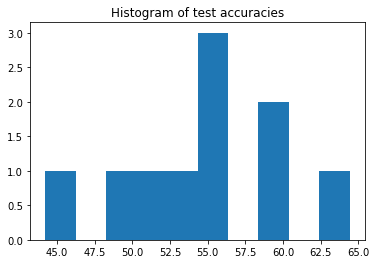

mean 54.7008547008547
stdev 5.412777392970396


In [22]:
import matplotlib.pyplot as plt
#acc = np.array(test_accuracy)
#np.append(acc, 54.700854700854705)
plt.hist(acc, bins=10)
plt.title(r'Histogram of test accuracies')
plt.show()
mean = np.mean(acc)
print("mean", mean)
print("stdev", np.std(acc))

In [23]:
plt.savefig(histogram_rnn, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

NameError: name 'histogram_rnn' is not defined

In [21]:
acc = np.append(acc, 54.700854700854705)

In [24]:
acc

array([64.42307692, 59.61538462, 44.23076923, 55.76923077, 53.84615385,
       55.76923077, 50.96153846, 58.65384615, 49.03846154, 54.7008547 ])

In [12]:
print(test_accuracy)

[64.42307692307692, 59.61538461538461, 44.23076923076923, 55.76923076923077, 53.84615384615385, 55.76923076923077, 50.96153846153846, 58.65384615384615, 49.03846153846154]


In [14]:
print(test_accuracy)

[63.46153846153846]
